In [1]:
import torch
import json
import numpy as np
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from gpt_model import GPTModel
from sparse_auto_encoder import SparseAutoencoder

In [2]:
device = "cpu"
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.2,
    "qkv_bias": True,
    "device": "cpu",
}

In [3]:
model = GPTModel(GPT_CONFIG_124M)
checkpoint = torch.load("model_768_12_12_old_tok.pth", weights_only=True, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval();

In [4]:
tokenizer = tiktoken.get_encoding("gpt2")

In [5]:
sae_6 = SparseAutoencoder(input_dim=768, hidden_dim=3072).to(device)
sae_6.load_state_dict(torch.load("sae_model_6_3072.pth", map_location=torch.device('cpu')))
sae_6.eval();

sae_12 = SparseAutoencoder(input_dim=768, hidden_dim=3072).to(device)
sae_12.load_state_dict(torch.load("sae_model_12_3072.pth", map_location=torch.device('cpu')))
sae_12.eval();

In [6]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [7]:
def get_token_embeddings(text, model, tokenizer, layers=[6, 12]):
    """
    Extracts token embeddings from specified transformer layers.

    Args:
    - text (str): Input text.
    - model: Custom GPT model.
    - tokenizer: tiktoken encoding object.
    - layers (list): Transformer layers to extract embeddings from.

    Returns:
    - dict: Layer-wise token embeddings {layer_number: embeddings}
    """

    input_ids = text_to_token_ids(text, tokenizer).to(device)

    with torch.no_grad():
        _, hidden_states = model(input_ids, output_hidden_states=True)

    embeddings = {} 
    for layer in layers:
        if layer - 1 < len(hidden_states):
            embeddings[layer] = hidden_states[layer - 1].squeeze(0).cpu().numpy()
        else:
            print(f"⚠️ Warning: Layer {layer} is out of range (max index {len(hidden_states) - 1})")

    return embeddings

In [8]:
with open("theme_bias_analysis.json", "r", encoding="utf-8") as f:
    concept_to_texts = json.load(f)

sentences = []
for concept in concept_to_texts:
    sentences += concept_to_texts[concept]

print(f"Total of {len(sentences)} sentences accross {len(concept_to_texts)} concepts.")

inputs = [text_to_token_ids(text, tokenizer) for text in sentences]

Total of 318 sentences accross 11 concepts.


In [9]:
def exract_latent_activations(sae, layer):
    all_latents = []
    for sentence in sentences:
        idx = text_to_token_ids(sentence, tokenizer)
    
        # Get hidden state from the layer
        with torch.no_grad():
            _, hidden_states, attn_weights = model(idx, output_hidden_states=True, output_attentions_weights=True)
            h_layer = hidden_states[layer - 1][0]
            
            attn = attn_weights[layer - 1][0]  # [n_heads, seq_len, seq_len]
            attn_to_all = attn[:, -1, :]           # attention from final token to all tokens
            avg_attn_weights = attn_to_all.mean(dim=0)  # shape: [seq_len]

            weighted_hidden = torch.sum(h_layer * avg_attn_weights.unsqueeze(1), dim=0)  # shape: [emb_dim]
    
            # SAE encode + top-k
            x = weighted_hidden.unsqueeze(0) - sae.decoder.bias - sae.pre_encoder_bias
            z = sae.encoder(x)
            z = sae.topk(z)
    
            all_latents.append(z.squeeze(0))
    
    latent_activations = torch.stack(all_latents)
    torch.save(latent_activations, f"latent_activations_l{layer}.pt")
    print(f"✅ Saved latent_activations_l{layer}.pt with shape:", latent_activations.shape)

    return latent_activations

In [10]:
def get_selective_neurons(latent_activations, layer=6):
    # Count how many examples each neuron fires on with value > 5
    activation_counts = (latent_activations > 5).sum(dim=0)  # shape: [3072]
    
    # Define selectivity range: not too rare, not too general
    min_active, max_active = 5, 150
    selective_neurons = [
        idx for idx, count in enumerate(activation_counts.tolist())
        if min_active <= count <= max_active
    ]
    
    # Save for further analysis
    torch.save(selective_neurons, f"selective_neuron_ids_l{layer}.pt")
    
    # Optional: Show distribution
    df = pd.DataFrame({
        "Neuron ID": list(range(latent_activations.shape[1])),
        "Activation Count": activation_counts.tolist(),
        "Is Selective": [i in selective_neurons for i in range(latent_activations.shape[1])]
    })
    
    print(df[df["Is Selective"]].sort_values("Activation Count", ascending=False))

    return selective_neurons

In [11]:
# Load saved tensors
# latent_activations = torch.load("latent_activations.pt")  # shape: [210, 3072]
# selective_neurons = torch.load("selective_neuron_ids.pt")  # list of neuron indices

def get_topk_activ_sentences(latent_activations, selective_neurons, layer=6, top_k=10, print_results=False):
    # Dictionary to store results
    neuron_top_sentences = {}
    
    for neuron in selective_neurons:
        activations = latent_activations[:, neuron]
        top_vals, top_indices = torch.topk(activations, k=top_k)
        top_sents = [sentences[i] for i in top_indices]
        neuron_top_sentences[neuron] = top_sents
    
    
    with open(f"selective_neuron_top_sentences_l{layer}.json", "w") as f:
        json.dump(neuron_top_sentences, f, indent=2)
    
    # Print out results for inspection
    if print_results:
        for neuron, sents in neuron_top_sentences.items():
            print(f"\nNeuron {neuron} (Top {top_k} activations):")
            for s in sents:
                print("  ", s)

    return neuron_top_sentences

In [12]:
# with open("selective_neuron_top_sentences.json", "r") as f:
#     neuron_sentences = json.load(f)

def get_neuron_theme_analysis(concept_to_texts, neuron_sentences, layer=6):
    # === Invert theme-to-sentence to sentence-to-theme ===
    sentence_to_theme = {}
    for theme, top_sentences in concept_to_texts.items():
        for sent in top_sentences:
            sentence_to_theme[sent] = theme
    
    # === Analyze Each Neuron ===
    neuron_theme_analysis = {}
    
    for neuron, top_sents in neuron_sentences.items():
        theme_counts = defaultdict(int)
    
        for sent in top_sents:
            if sent in sentence_to_theme:
                theme = sentence_to_theme[sent]
                theme_counts[theme] += 1
    
        # Sort by frequency
        sorted_themes = sorted(theme_counts.items(), key=lambda x: x[1], reverse=True)
    
        primary = {"category": "UNK", "count": 0}
        secondary = {"category": "UNK", "count": 0}
    
        if sorted_themes:
            if sorted_themes[0][1] >= 4 and primary["category"] == "UNK":
                primary = {"category": sorted_themes[0][0], "count": sorted_themes[0][1]}
            elif sorted_themes[0][1] > 2:
                secondary = {"category": sorted_themes[0][0], "count": sorted_themes[0][1]}
    
            if len(sorted_themes) > 1 and secondary["category"] == "UNK":
                if sorted_themes[1][1] > 1:
                    secondary = {"category": sorted_themes[1][0], "count": sorted_themes[1][1]}
    
        neuron_theme_analysis[neuron] = {
            "primary_category": primary["category"],
            "primary_count": primary["count"],
            "secondary_category": secondary["category"],
            "secondary_count": secondary["count"]
        }
    
    # === Save to JSON ===
    with open(f"neuron_theme_mapping_l{layer}.json", "w") as f:
        json.dump(neuron_theme_analysis, f, indent=2)
    
    print("✅ Saved neuron mappings to neuron_theme_mapping.json")
    return neuron_theme_analysis

In [13]:
# Load the JSON file
# with open("neuron_theme_mapping.json", "r") as f:
#     neuron_theme_mapping = json.load(f)


def get_dual_themed_neurons(neuron_theme_mapping):
    found = False
        
    # Loop through each neuron and check for both categories
    for neuron, info in neuron_theme_mapping.items():
        primary = info["primary_category"].strip().lower()
        secondary = info["secondary_category"].strip().lower()
    
        if primary != "unk" and secondary != "unk":
            found = True
            print(f"Neuron {neuron}: primary = {primary}, secondary = {secondary}")
    
    if not found:
        print("No dual concept neurons found!")

In [14]:
def plot_concept_similarity_matrix(neuron_theme_mapping, title="Concept Similarity Matrix"):
    # Count co-occurrences
    co_occurrence = defaultdict(lambda: defaultdict(int))
    concepts = set()

    for neuron, info in neuron_theme_mapping.items():
        primary = info["primary_category"].strip().lower()
        secondary = info["secondary_category"].strip().lower()

        if primary != "unk" and secondary != "unk":
            co_occurrence[primary][secondary] += 1
            concepts.add(primary)
            concepts.add(secondary)

    concepts = sorted(concepts)
    
    # Create a DataFrame matrix
    matrix = pd.DataFrame(0, index=concepts, columns=concepts)
    for primary in concepts:
        for secondary in concepts:
            matrix.loc[primary, secondary] = co_occurrence[primary][secondary]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
    plt.title(title)
    plt.xlabel("Secondary Concept")
    plt.ylabel("Primary Concept")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [15]:
def get_strongest_associations(layer_idx):
    """
    Load a neuron-theme mapping JSON file for the given layer, 
    extract neurons with primary concepts, and return a DataFrame 
    sorted by primary_count in descending order.
    
    Parameters:
        layer_idx (int): The transformer layer index.
        path_template (str): Template string for the file path. 
                             Must include one {} placeholder for layer index.
                             
    Returns:
        pd.DataFrame: A DataFrame with columns:
            ['neuron idx', 'associated concept', 'activations count', 'secondary concept']
    """
    
    with open(f"neuron_theme_mapping_l{layer_idx}.json", "r") as f:
        data = json.load(f)

    records = []

    for neuron, info in data.items():
        primary = info.get("primary_category", "").strip().lower()
        primary_count = info.get("primary_count", 0)
        secondary = info.get("secondary_category", "").strip().lower()

        if primary and primary != "unk":
            records.append({
                "neuron idx": int(neuron),
                "associated concept": primary,
                "activations count": primary_count,
                "secondary concept": secondary if secondary and secondary != "unk" else None
            })

    df = pd.DataFrame(records)
    df.sort_values(by="activations count", ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [16]:
latent_activations_6 = exract_latent_activations(sae_6, layer=6)

print(50*'---')
print('Selecive neurons:')
selective_neurons_6 = get_selective_neurons(latent_activations_6, layer=6)
print(50*'---')

neuron_top_sentences_6 = get_topk_activ_sentences(latent_activations_6, selective_neurons_6, top_k=10, layer=6)
neuron_theme_mapping_6 = get_neuron_theme_analysis(concept_to_texts, neuron_top_sentences_6, layer=6)

print(50*'---')
print('Dual themed neurons:')
get_dual_themed_neurons(neuron_theme_mapping_6)

✅ Saved latent_activations_l6.pt with shape: torch.Size([318, 3072])
------------------------------------------------------------------------------------------------------------------------------------------------------
Selecive neurons:
      Neuron ID  Activation Count  Is Selective
639         639               122          True
1049       1049                65          True
1557       1557                61          True
971         971                39          True
2954       2954                39          True
272         272                34          True
2064       2064                32          True
1526       1526                31          True
830         830                24          True
368         368                21          True
1796       1796                20          True
1813       1813                18          True
1929       1929                14          True
1349       1349                14          True
1664       1664                12         

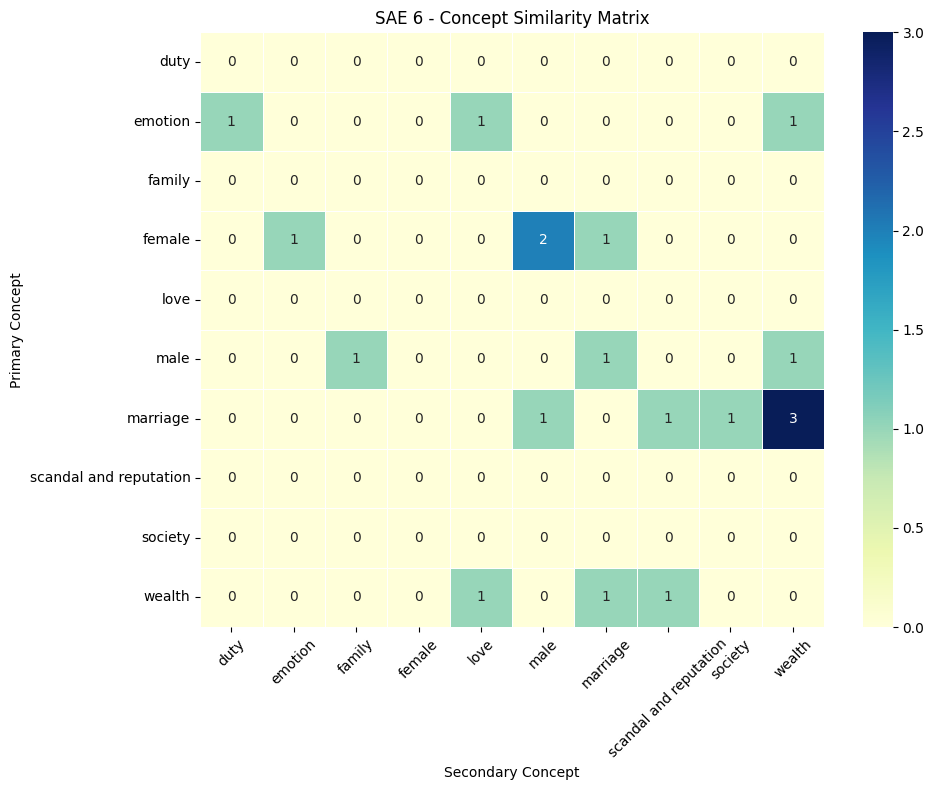

In [17]:
plot_concept_similarity_matrix(neuron_theme_mapping_6, title="SAE 6 - Concept Similarity Matrix")

In [18]:
get_strongest_associations(6)

,neuron idx,associated concept,activations count,secondary concept
0,2362,female,7,male
1,624,female,6,emotion
2,732,wealth,5,love
3,639,female,5,marriage
4,1526,marriage,5,wealth
5,368,marriage,5,wealth
6,2587,female,5,male
7,2593,marriage,5,None
8,1929,marriage,5,wealth
9,1557,marriage,5,scandal and reputation


In [19]:
latent_activations_12 = exract_latent_activations(sae_12, layer=12)

print(50*'---')
print('Selecive neurons:')
selective_neurons_12 = get_selective_neurons(latent_activations_12, layer=12)
print(50*'---')

neuron_top_sentences_12 = get_topk_activ_sentences(latent_activations_12, selective_neurons_12, top_k=10, layer=12)
neuron_theme_mapping_12 = get_neuron_theme_analysis(concept_to_texts, neuron_top_sentences_12, layer=12)

print(50*'---')
print('Dual themed neurons:')
get_dual_themed_neurons(neuron_theme_mapping_12)

✅ Saved latent_activations_l12.pt with shape: torch.Size([318, 3072])
------------------------------------------------------------------------------------------------------------------------------------------------------
Selecive neurons:
      Neuron ID  Activation Count  Is Selective
2753       2753               138          True
2235       2235               137          True
2623       2623               118          True
698         698               114          True
2429       2429               112          True
...         ...               ...           ...
421         421                 5          True
1906       1906                 5          True
1909       1909                 5          True
1720       1720                 5          True
2669       2669                 5          True

[107 rows x 3 columns]
------------------------------------------------------------------------------------------------------------------------------------------------------
✅ Saved ne

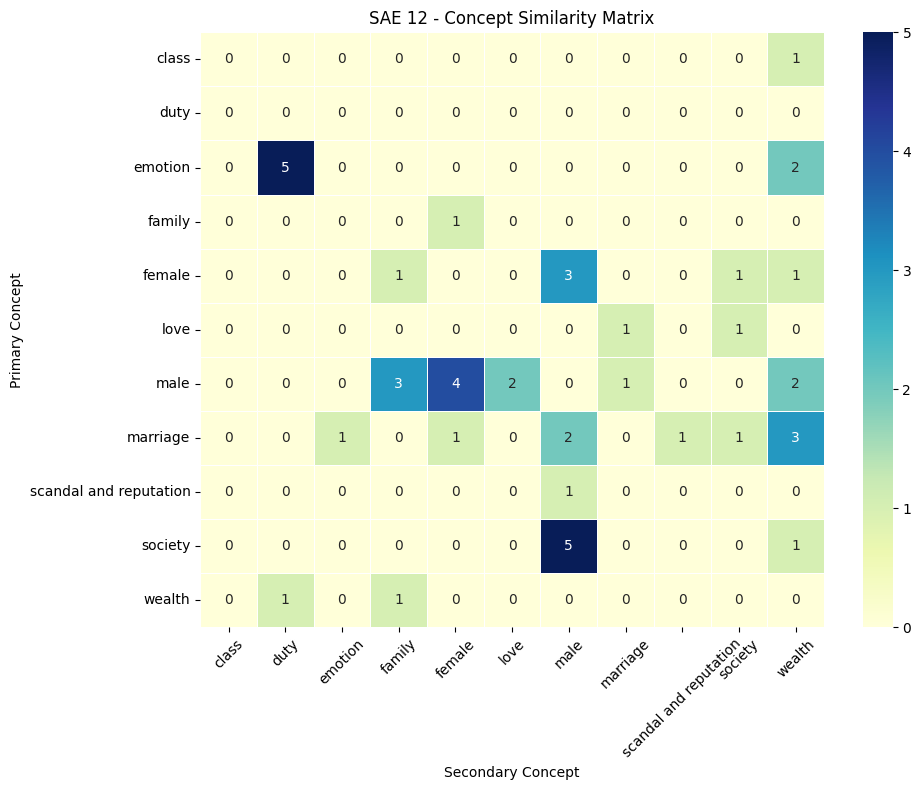

In [20]:
plot_concept_similarity_matrix(neuron_theme_mapping_12, title="SAE 12 - Concept Similarity Matrix")

In [21]:
get_strongest_associations(12)

,neuron idx,associated concept,activations count,secondary concept
0,2952,male,10,None
1,255,female,7,male
2,800,female,6,male
3,1886,marriage,6,wealth
4,2012,emotion,6,duty
5,1647,male,6,female
6,244,female,5,wealth
7,981,emotion,5,wealth
8,1337,emotion,5,wealth
9,421,male,5,wealth


In [25]:
import torch.nn.functional as F

from utils import text_to_token_ids

def compute_concept_similarity_heatmap(
    model,
    sae,
    tokenizer,
    json_path="theme_bias_analysis.json",
    device="cpu",
    layer_idx=6
):
    # 1. Load data
    with open(json_path, "r") as f:
        concept_dict = json.load(f)

    concept_embeddings = {}

    # 2. For each concept, compute average SAE vector
    for concept, sentences in concept_dict.items():
        sae_latents = []

        for sentence in sentences:
            input_ids = text_to_token_ids(sentence, tokenizer).to(device)
            with torch.no_grad():
                # Get logits, hidden states, and attention weights
                _, hidden_states, attn_weights = model(
                    input_ids,
                    output_hidden_states=True,
                    output_attentions_weights=True
                )

                # Extract hidden state from desired layer
                layer_hidden = hidden_states[layer_idx - 1][0]  # shape: [seq_len, emb_dim]

                # Attention weights from last token, averaged over heads
                attn = attn_weights[layer_idx - 1][0]  # [n_heads, seq_len, seq_len]
                attn_to_all = attn[:, -1, :]           # attention from final token to all tokens
                avg_attn_weights = attn_to_all.mean(dim=0)  # shape: [seq_len]

                # Apply attention weighting
                weighted_hidden = torch.sum(layer_hidden * avg_attn_weights.unsqueeze(1), dim=0)  # shape: [emb_dim]

            sae_latents.append(weighted_hidden.squeeze(0))          # shape: [sae_dim]

        # Average SAE latent vectors for this concept
        concept_embeddings[concept] = torch.stack(sae_latents).mean(dim=0)

    # 3. Compute cosine similarity matrix
    labels = list(concept_embeddings.keys())
    vectors = torch.stack([concept_embeddings[l] for l in labels])
    sim_matrix = F.cosine_similarity(vectors.unsqueeze(1), vectors.unsqueeze(0), dim=2).cpu()

    # 4. Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix.detach().numpy(), xticklabels=labels, yticklabels=labels, cmap="flare", annot=True, fmt=".2f")
    plt.title(f"Concept Similarity Heatmap (SAE Layer {layer_idx} space)")
    plt.tight_layout()
    plt.show()

    return sim_matrix, labels

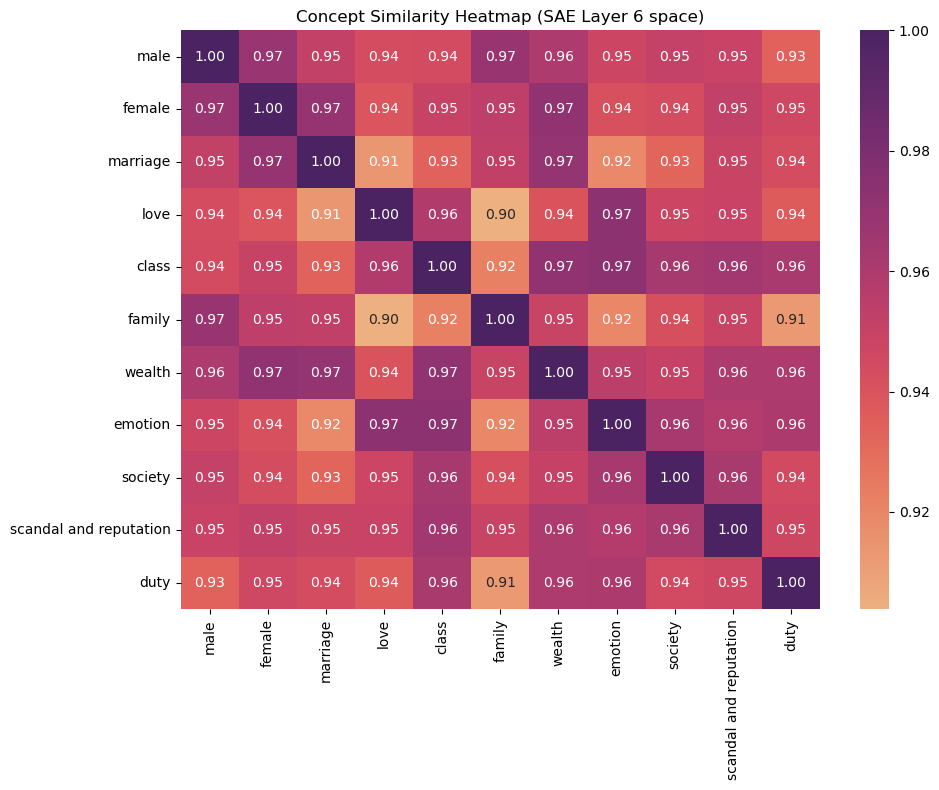

(tensor([[1.0000, 0.9681, 0.9516, 0.9438, 0.9442, 0.9687, 0.9603, 0.9472, 0.9509,
          0.9496, 0.9337],
         [0.9681, 1.0000, 0.9696, 0.9393, 0.9503, 0.9537, 0.9718, 0.9414, 0.9433,
          0.9520, 0.9464],
         [0.9516, 0.9696, 1.0000, 0.9143, 0.9336, 0.9530, 0.9707, 0.9192, 0.9325,
          0.9491, 0.9436],
         [0.9438, 0.9393, 0.9143, 1.0000, 0.9585, 0.9038, 0.9400, 0.9733, 0.9477,
          0.9493, 0.9366],
         [0.9442, 0.9503, 0.9336, 0.9585, 1.0000, 0.9222, 0.9713, 0.9732, 0.9628,
          0.9645, 0.9620],
         [0.9687, 0.9537, 0.9530, 0.9038, 0.9222, 1.0000, 0.9489, 0.9197, 0.9419,
          0.9491, 0.9132],
         [0.9603, 0.9718, 0.9707, 0.9400, 0.9713, 0.9489, 1.0000, 0.9545, 0.9506,
          0.9599, 0.9601],
         [0.9472, 0.9414, 0.9192, 0.9733, 0.9732, 0.9197, 0.9545, 1.0000, 0.9622,
          0.9577, 0.9606],
         [0.9509, 0.9433, 0.9325, 0.9477, 0.9628, 0.9419, 0.9506, 0.9622, 1.0000,
          0.9617, 0.9447],
         [0.9496, 0

In [26]:
compute_concept_similarity_heatmap(model, sae_6, tokenizer, layer_idx=6)

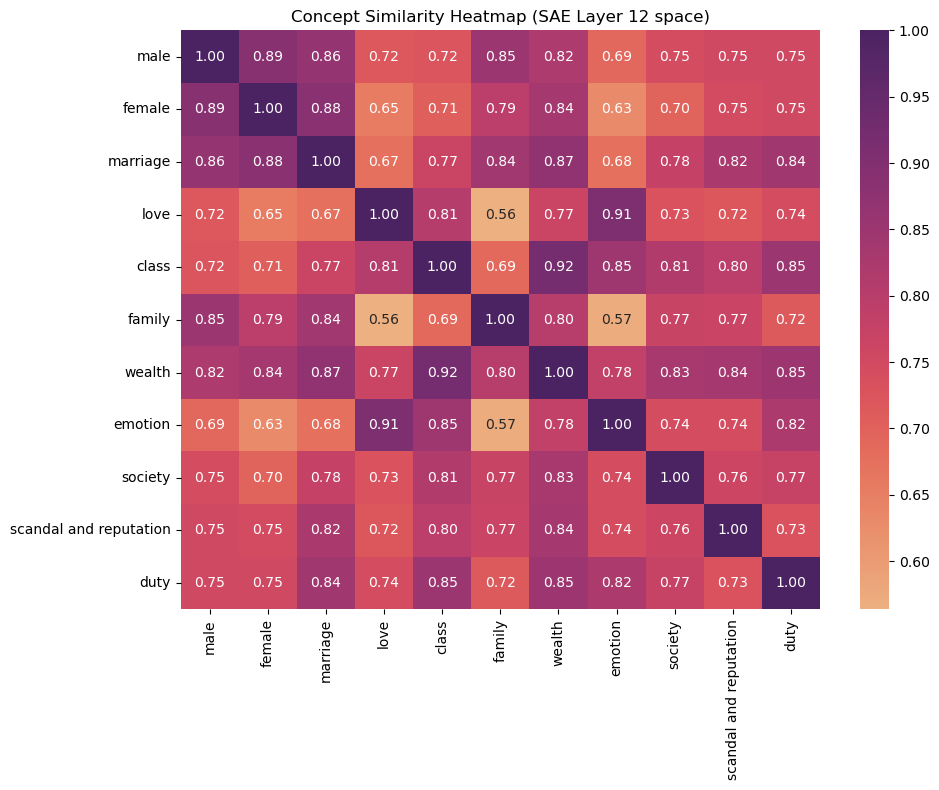

(tensor([[1.0000, 0.8868, 0.8645, 0.7172, 0.7243, 0.8532, 0.8180, 0.6901, 0.7458,
          0.7517, 0.7534],
         [0.8868, 1.0000, 0.8843, 0.6548, 0.7058, 0.7944, 0.8351, 0.6284, 0.6952,
          0.7470, 0.7532],
         [0.8645, 0.8843, 1.0000, 0.6745, 0.7660, 0.8404, 0.8689, 0.6756, 0.7759,
          0.8249, 0.8416],
         [0.7172, 0.6548, 0.6745, 1.0000, 0.8061, 0.5636, 0.7662, 0.9050, 0.7294,
          0.7189, 0.7437],
         [0.7243, 0.7058, 0.7660, 0.8061, 1.0000, 0.6865, 0.9194, 0.8468, 0.8114,
          0.7953, 0.8513],
         [0.8532, 0.7944, 0.8404, 0.5636, 0.6865, 1.0000, 0.8005, 0.5713, 0.7689,
          0.7670, 0.7150],
         [0.8180, 0.8351, 0.8689, 0.7662, 0.9194, 0.8005, 1.0000, 0.7823, 0.8302,
          0.8359, 0.8499],
         [0.6901, 0.6284, 0.6756, 0.9050, 0.8468, 0.5713, 0.7823, 1.0000, 0.7434,
          0.7433, 0.8215],
         [0.7458, 0.6952, 0.7759, 0.7294, 0.8114, 0.7689, 0.8302, 0.7434, 1.0000,
          0.7629, 0.7728],
         [0.7517, 0

In [27]:
compute_concept_similarity_heatmap(model, sae_12, tokenizer, layer_idx=12)

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

color_map = {
    "female": "#FAD7AC",
    "male": "#cc9290",
    "marriage": "#ed76b3",
    "love": "#f4847a",
    "wealth": "#DAE8FC",
    "emotion": "#9467bd",
    "family": "#D0CEE1",
    "duty": "#a4d9f2",
    "scandal and reputation": "#BAC8D3",
    "society": "#D5E7D4",
    "neutral": "#e5ced0",
    "class": "#FFF1CC"
}

def plot_dual_theme_graph(data):
    """
    Plots a graph of concepts linked by dual-themed SAE neurons.
    
    Parameters:
    - data: dict, the parsed JSON data mapping neuron IDs to theme info
    - color_map: dict[str, str], maps each concept name to a hex color
    """
    # 1. Extract edges from dual-themed neurons
    edges = []
    for neuron_id, info in data.items():
        primary = info["primary_category"].strip().strip(",").lower()
        secondary = info["secondary_category"].strip().strip(",").lower()
        
        if primary != "unk" and secondary != "unk":
            edges.append((primary, secondary))

    # 2. Build multi-edge graph
    G = nx.MultiGraph()
    G.add_edges_from(edges)
    
    # 3. Position and draw
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=0.75, seed=62)

    # Node sizes and consistent colors
    unique_nodes = list(G.nodes())
    node_colors = [color_map.get(node, "#cccccc") for node in unique_nodes]
    nx.draw_networkx_nodes(G, pos, node_size=8000, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

    # Draw edges with width based on number of dual-theme links
    drawn_edges = set()
    for u, v in G.edges():
        edge_key = tuple(sorted((u, v)))
        if edge_key not in drawn_edges:
            count = G.number_of_edges(u, v)
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=1 + count, alpha=0.5)
            drawn_edges.add(edge_key)

    plt.title("Dual-Theme SAE Neuron Concept Graph", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

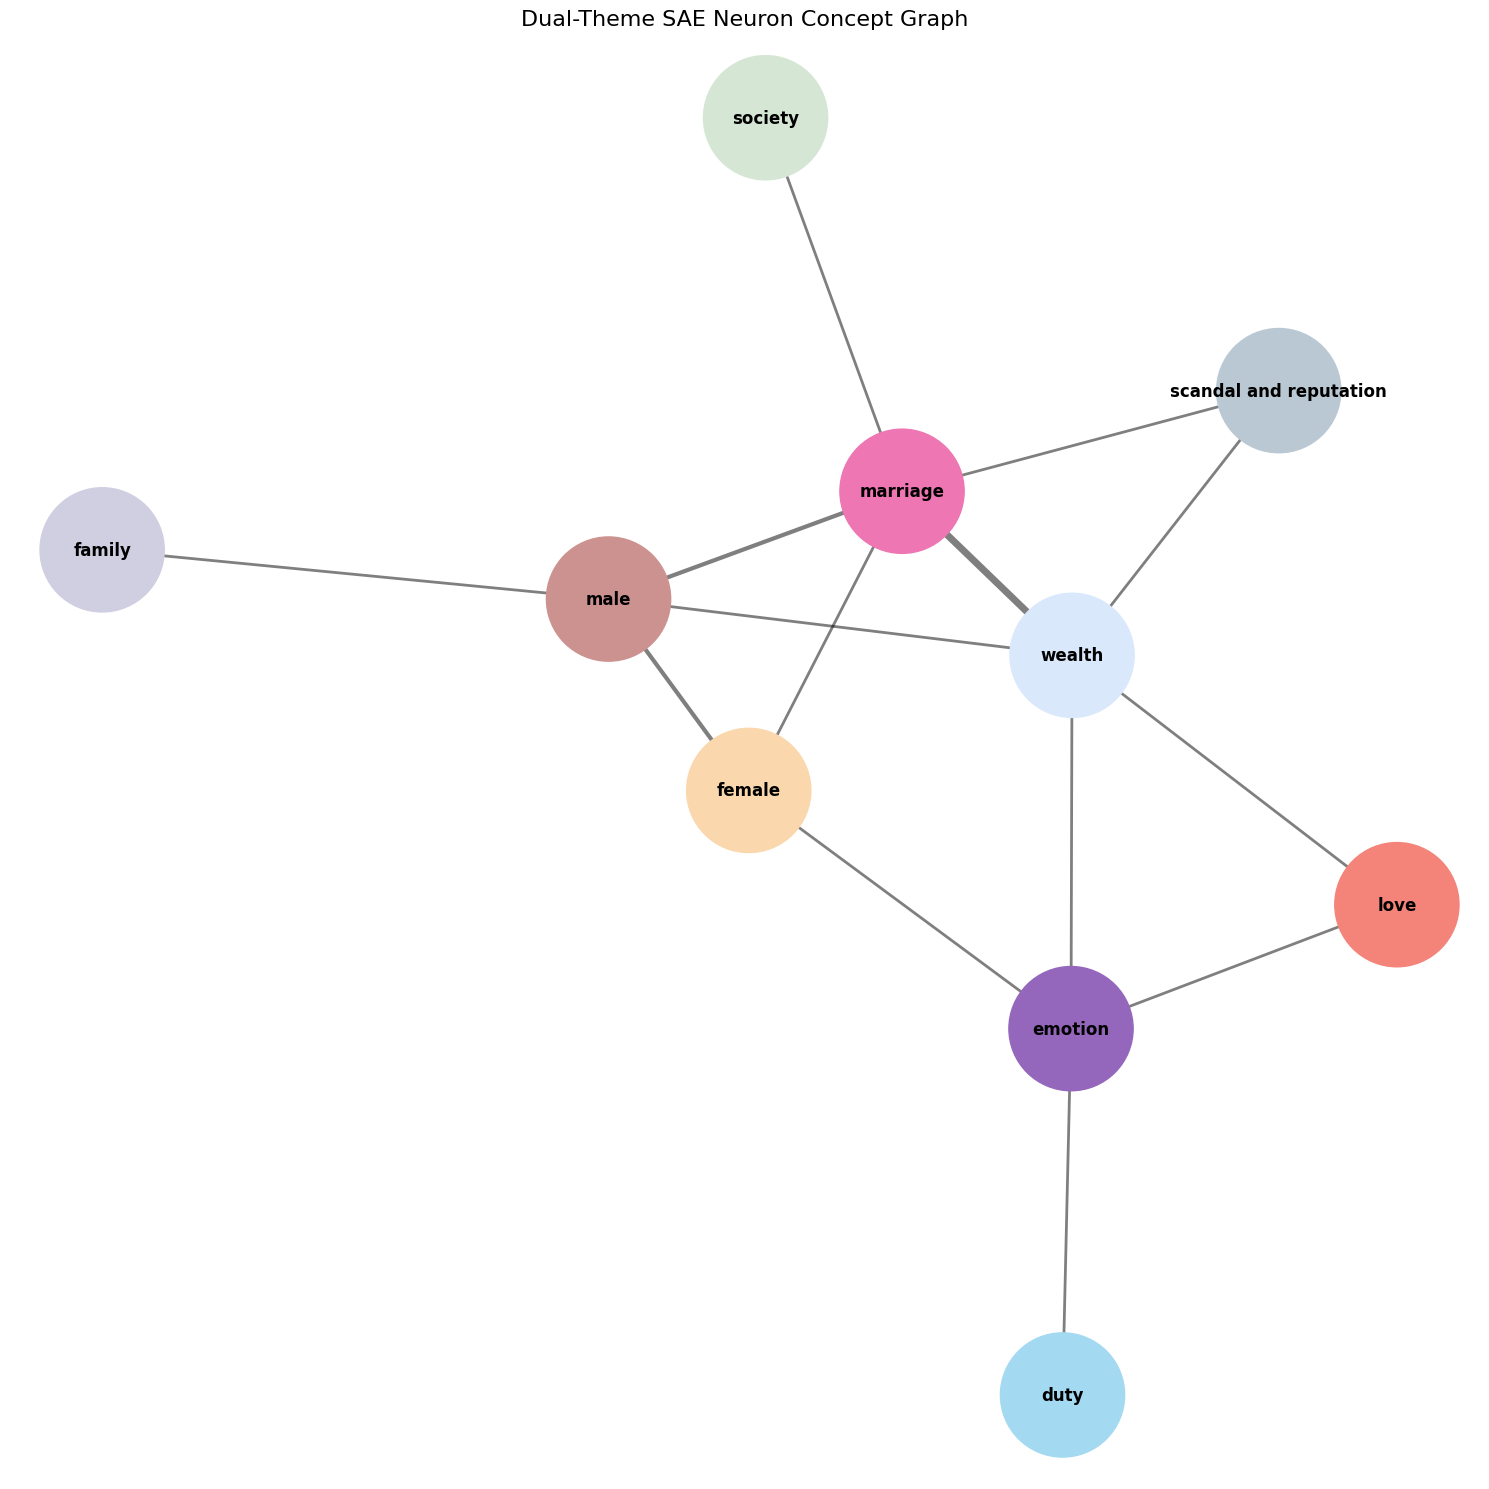

In [26]:
with open("neuron_theme_mapping_l6.json", "r") as f:
    data = json.load(f)

plot_dual_theme_graph(data)

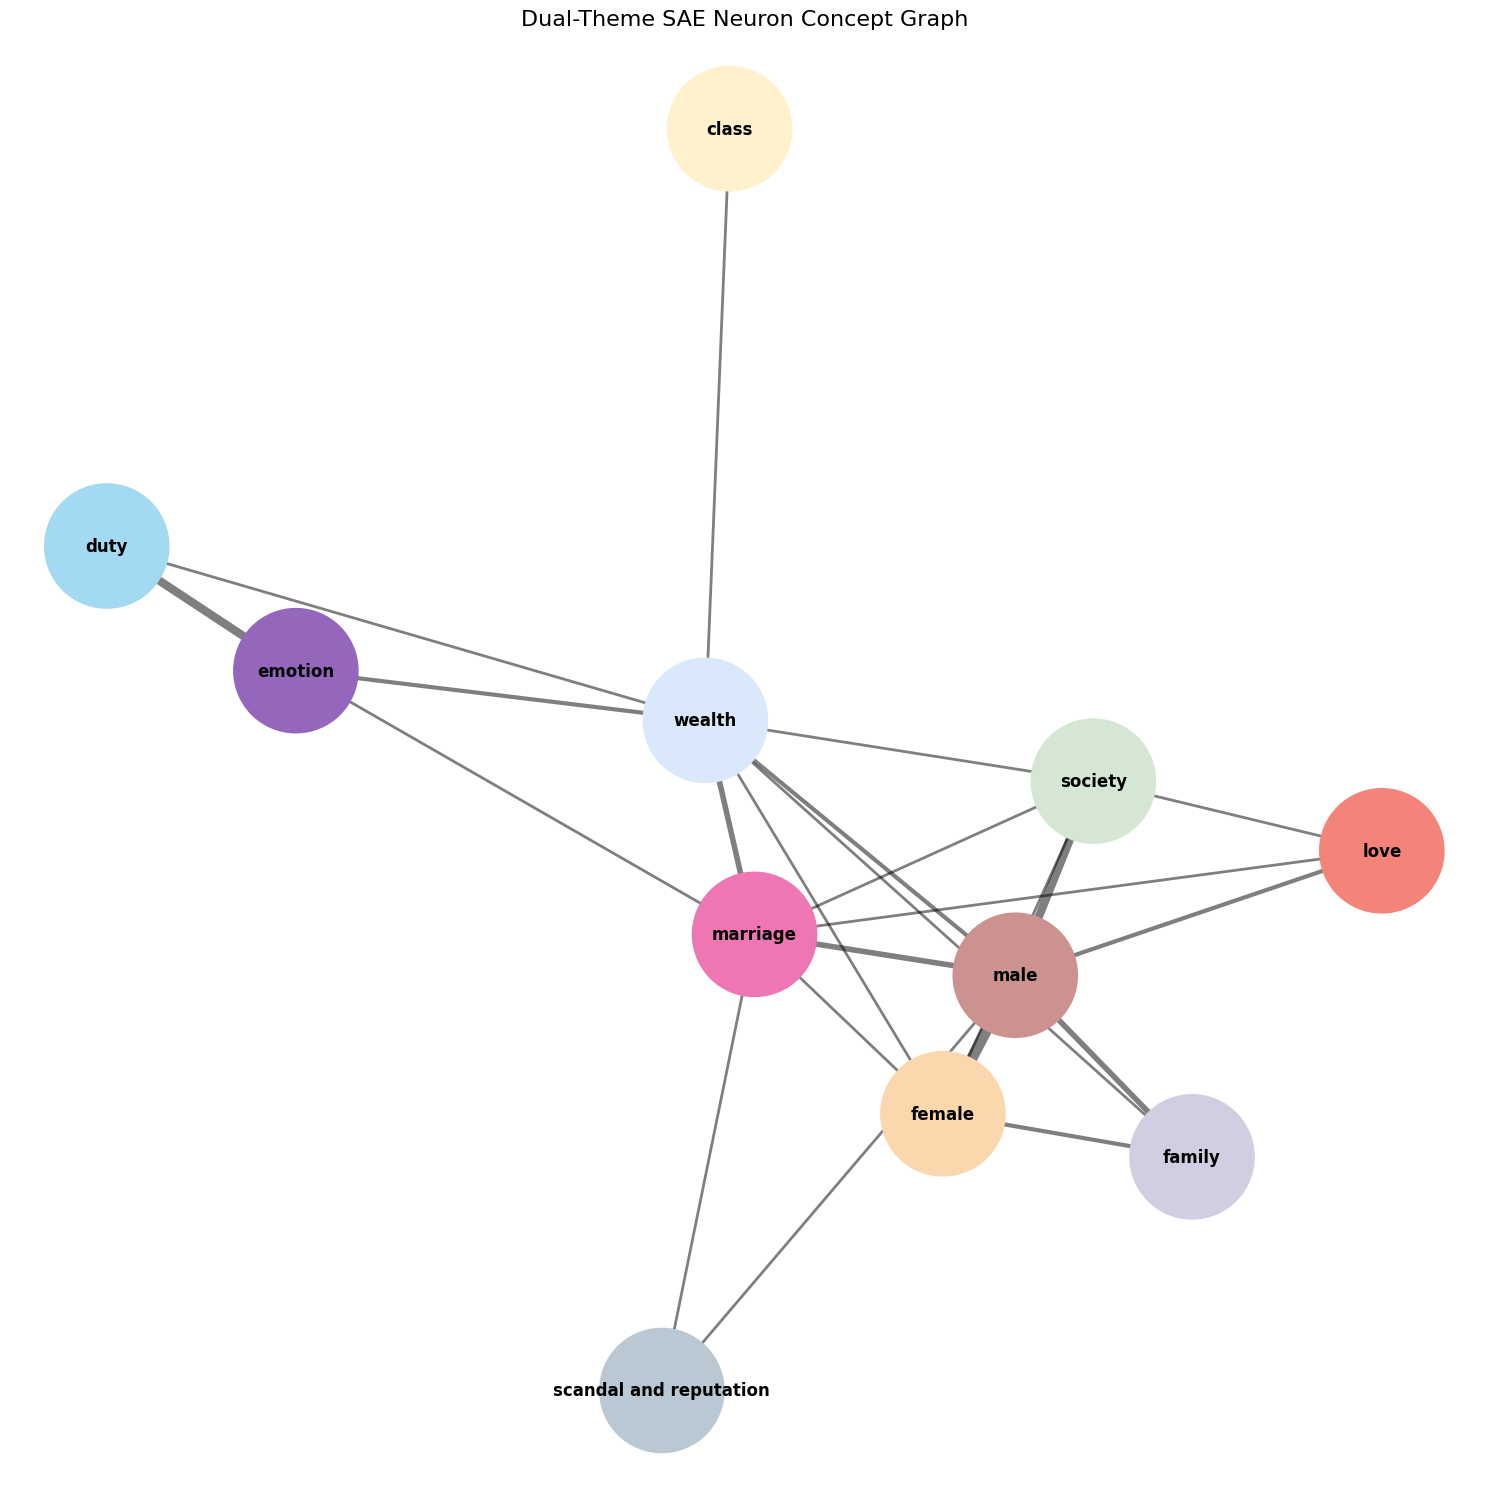

In [27]:
with open("neuron_theme_mapping_l12.json", "r") as f:
    data = json.load(f)

plot_dual_theme_graph(data)